In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import requests
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# In current directory, since path is not specified.
if not os.path.exists('cats_and_dogs.zip'):
    url = 'https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip'
    response = requests.get(url)
    with open('cats_and_dogs.zip', 'wb') as file:
        file.write(response.content)
    with ZipFile('cats_and_dogs.zip', 'r') as zipObj:
        zipObj.extractall() 

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 160
IMG_WIDTH = 160

### CNN Model

In [ ]:
# Locate a file and delete it.
# ds_store_path = os.path.join(test_dir, '.DS_Store')
# if os.path.exists(ds_store_path):
#   os.remove(ds_store_path)
#   print('File removed')
# print(os.listdir(test_dir))

In [ ]:
# Create dummy class directory for test data
dummy_sub = os.path.join(test_dir, 'dummy_class')
os.makedirs(dummy_sub, exist_ok=True)

In [ ]:
# Move all test data to dummy class directory
import glob
all_files_path = glob.glob(os.path.join(test_dir, '*.jpg'))
for file_path in all_files_path:
  dst_path = os.path.join(dummy_sub, os.path.basename(file_path))
  os.rename(file_path, dst_path)

In [ ]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size, class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(validation_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size, class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=8, shuffle=False, class_mode=None)
# or...
# test_data_gen = test_image_generator.flow_from_directory(PATH, target_size=(IMG_HEIGHT, IMG_WIDTH),
#         batch_size=8, shuffle=False, classes=['test'], class_mode='binary')

In [ ]:
print(train_data_gen.class_indices)
print(f'Found {len(train_data_gen.filenames)} images in this directory.')

In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
# 5
# Create more training data from existing training examples by using random transformations
train_image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True,
                                           rotation_range=30, fill_mode='nearest',
                                           brightness_range=[0.4,1.5],
                                           zoom_range=0.3,
                                           width_shift_range=0.2, height_shift_range=0.2)


In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [ ]:
# 7
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Binary classification
# Predicting a single value at output (probability of being a dog or a cat).
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Multi-class classification
# model.add(Dense(num_classes, activation='softmax'))
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
len(train_data_gen) # 2000/128 -> total_training_samples / batch_size

In [ ]:
# 8
history = model.fit(x=train_data_gen, validation_data=val_data_gen, epochs=epochs,
                    steps_per_epoch=len(train_data_gen),
                    validation_steps=len(val_data_gen), verbose=1)
model.save('cats_dogs.keras')

In [ ]:
model = tf.keras.load_model('cats_dogs.keras')

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model.predict(x=test_data_gen, verbose=0)
predictions[:5]

# or ... if sparse_categorical_crossentropy is used
# pred = model.predict(x=test_data_gen, verbose=0)
# probabilities = np.argmax(pred, axis=-1)
# array([[0.42858884, 0.57141113],
#        [0.6647593 , 0.33524072],
#        [0.645472  , 0.35452798],

In [ ]:
test_images, _ = next(test_data_gen)
plotImages(test_images, probabilities=predictions)

In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

probabilities = [1 if prediction > 0.5 else 0 for prediction in predictions]

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

In [ ]:
import itertools
cm = tf.math.confusion_matrix(labels=answers, predictions=probabilities)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
      cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### Using a Pre-Trained Model

In [2]:
import os

folder_name = 'Cat and Dog Image Classifier'
# os.getcwd()
data_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(data_dir, exist_ok=True)

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [3]:
train_image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)
validation_image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)
test_image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

train_data_gen = train_image_generator.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size, class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(validation_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size, class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(PATH, target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=50, shuffle=False, classes=['test'], class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [4]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False
base_model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [5]:
x = base_model.output

# Add a new classifier layer for transfer learning
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the model
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']           

In [7]:
# Evaluate the model before training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

loss0, accuracy0 = model.evaluate(val_data_gen)

8/8 [==============================] - 4s 429ms/step - loss: 0.6424 - accuracy: 0.6340


In [8]:
# Train the model
history = model.fit(x=train_data_gen, validation_data=val_data_gen, epochs=5,
                    steps_per_epoch=len(train_data_gen),
                    validation_steps=len(val_data_gen), verbose=2)

Epoch 1/15
16/16 - 19s - loss: 0.3670 - accuracy: 0.8620 - val_loss: 0.1853 - val_accuracy: 0.9610 - 19s/epoch - 1s/step
Epoch 2/15
16/16 - 10s - loss: 0.1469 - accuracy: 0.9595 - val_loss: 0.1122 - val_accuracy: 0.9710 - 10s/epoch - 656ms/step
Epoch 3/15
16/16 - 11s - loss: 0.1028 - accuracy: 0.9700 - val_loss: 0.0920 - val_accuracy: 0.9770 - 11s/epoch - 671ms/step
Epoch 4/15
16/16 - 11s - loss: 0.0850 - accuracy: 0.9735 - val_loss: 0.0801 - val_accuracy: 0.9760 - 11s/epoch - 670ms/step
Epoch 5/15
16/16 - 10s - loss: 0.0737 - accuracy: 0.9775 - val_loss: 0.0743 - val_accuracy: 0.9780 - 10s/epoch - 653ms/step
Epoch 6/15
16/16 - 11s - loss: 0.0659 - accuracy: 0.9800 - val_loss: 0.0687 - val_accuracy: 0.9780 - 11s/epoch - 662ms/step
Epoch 7/15
16/16 - 10s - loss: 0.0593 - accuracy: 0.9820 - val_loss: 0.0668 - val_accuracy: 0.9800 - 10s/epoch - 645ms/step
Epoch 8/15
16/16 - 11s - loss: 0.0545 - accuracy: 0.9820 - val_loss: 0.0617 - val_accuracy: 0.9820 - 11s/epoch - 661ms/step
Epoch 9/15


In [9]:
model.save('cats_dogs_transfer_learning.keras')

In [ ]:
model = tf.keras.load_model('cats_dogs_transfer_learning.keras')

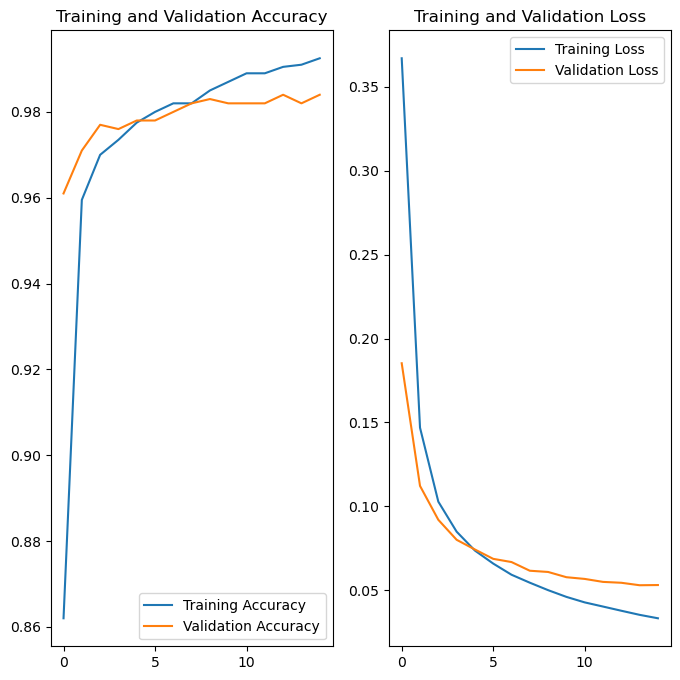

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
predictions = model.predict(x=test_data_gen, verbose=0)
predictions[:5]

array([[9.9639624e-01],
       [2.8076401e-04],
       [9.0008507e-05],
       [9.8337108e-01],
       [1.5492416e-04]], dtype=float32)

In [ ]:
test_images, _ = next(test_data_gen)
plotImages(test_images, probabilities=predictions)

In [18]:
import itertools

answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

probabilities = [1 if prediction > 0.5 else 0 for prediction in predictions]

cm = np.array(tf.math.confusion_matrix(labels=answers, predictions=probabilities))

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
      cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  

Confusion matrix, without normalization
[[26  0]
 [ 2 22]]


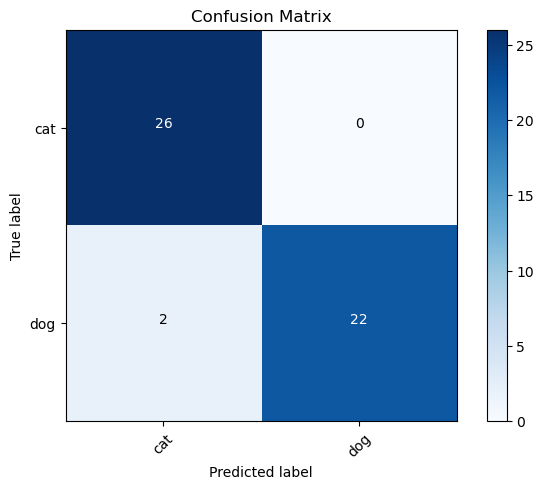

In [19]:
plot_confusion_matrix(cm=cm, classes=['cat', 'dog'], title='Confusion Matrix')